## Importing the libraries

In [430]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [431]:
file = r"../data/raw/Bank Customer Churn Prediction.csv"

In [432]:
df = pd.read_csv(file)
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [433]:
df.shape

(10000, 12)

## Data Analysis

<AxesSubplot: xlabel='churn', ylabel='count'>

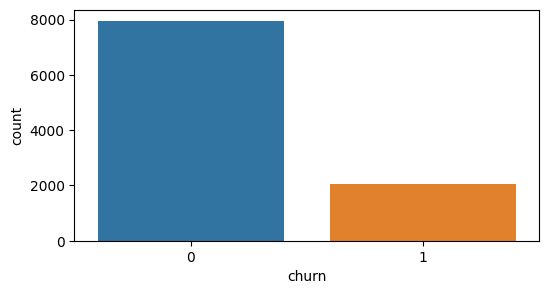

In [434]:
plt.figure(figsize=(6,3))
sns.countplot(x="churn", data=df)

In [435]:
churn_1 = len(df[df["churn"]==1])
churn_0 = len(df[df["churn"]==0])
ratio = churn_1/churn_0
ratio

0.25580811252040686

## Selecting the feature and target set

The model training does not depend on "customer_id" and we are not including it as a feature.

In [436]:
X = df.iloc[:,1:-1]
Y = df.iloc[:,-1]

In [437]:
X.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [438]:
X.shape

(10000, 10)

In [439]:
Y.head()

0    1
1    0
2    1
3    0
4    0
Name: churn, dtype: int64

## Checking for null values

In [440]:
null_cols = pd.DataFrame(X.isnull().sum(), columns=["sum"])
null_cols[null_cols["sum"] != 0]

,sum


## Train-Test Split

In [441]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)
xtrain, xtest, ytrain, ytest = train_test_split(xtrain, ytrain, test_size=0.1/(1-0.1), random_state=42, stratify=ytrain)

In [442]:
ytrain[:5]

5815    0
3876    0
5912    0
2634    1
8212    1
Name: churn, dtype: int64

In [443]:
df.iloc[3875:3877,-1]

3875    0
3876    0
Name: churn, dtype: int64

1629

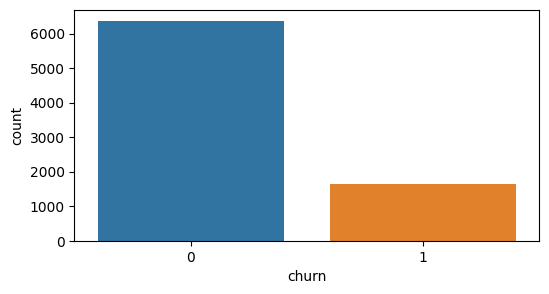

In [444]:
plt.figure(figsize=(6,3))
sns.countplot(x=ytrain[:])
ytrain[ytrain[:]==1].sum()

204

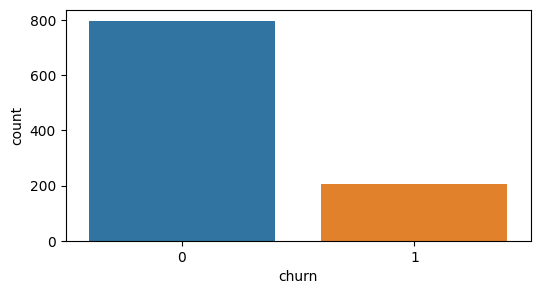

In [445]:
plt.figure(figsize=(6,3))
sns.countplot(x=ytest[:])
ytest[ytest[:]==1].sum()

<AxesSubplot: xlabel='churn', ylabel='count'>

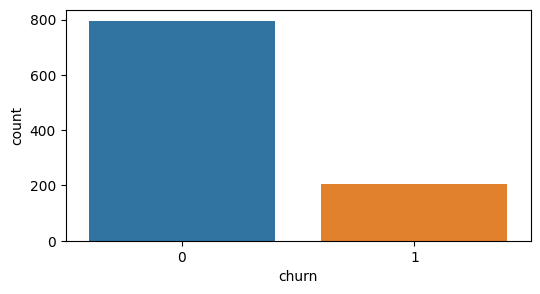

In [446]:
plt.figure(figsize=(6,3))
sns.countplot(x=yval[:])

## Pre-processsing the Data

Get all the numeric columns to standardise the values

In [447]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_X = X.select_dtypes(include=numerics)
numeric_cols = list(numeric_X.columns)
numeric_cols

['credit_score',
 'age',
 'tenure',
 'balance',
 'products_number',
 'credit_card',
 'active_member',
 'estimated_salary']

In [448]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

xtrain_scl1 = scaler.fit_transform(xtrain[numeric_cols])
xval_scl1 = scaler.transform(xval[numeric_cols])
xtest_scl1 = scaler.transform(xtest[numeric_cols])

Get all categorical columns and one-hot encode the values

In [449]:
features = X.columns
categorical_cols = list(set(features) - set(numeric_cols))
categorical_cols

['country', 'gender']

In [450]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

xtrain_scl2 = encoder.fit_transform(xtrain[categorical_cols])
xval_scl2 = encoder.transform(xval[categorical_cols])
xtest_scl2 = encoder.transform(xtest[categorical_cols])

In [451]:
xtrain_scl = np.hstack([xtrain_scl1, xtrain_scl2.todense()])
xval_scl = np.hstack([xval_scl1, xval_scl2.todense()])
xtest_scl = np.hstack([xtest_scl1, xtest_scl2.todense()])

In [452]:
xtrain_scl.shape

(7999, 13)

## Training the model (Non-Polynomial Logistic Regression)

In [453]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

In [454]:
log_reg = LogisticRegression()
log_reg.fit(np.asarray(xtrain_scl), ytrain)

LogisticRegression()

In [455]:
ypred = log_reg.predict(np.asarray(xval_scl))
ypred[:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [456]:
log_reg.score(np.asarray(xval_scl), yval)

0.799

In [457]:
cm = confusion_matrix(yval, ypred)
cm

array([[761,  35],
       [166,  38]], dtype=int64)

In [458]:
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
precision_score(yval, ypred)

0.5205479452054794

### Class weight: balanced

In [459]:
log_reg_bal = LogisticRegression(class_weight="balanced")
log_reg_bal.fit(np.asarray(xtrain_scl), ytrain)
ypredbal = log_reg.predict(np.asarray(xval_scl))
ypredbal[:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [460]:
log_reg_bal.score(np.asarray(xval_scl), yval)

0.698

In [461]:

cm = confusion_matrix(yval, ypredbal)
cm

array([[761,  35],
       [166,  38]], dtype=int64)

In [462]:
precision_score(yval, ypredbal)

0.5205479452054794

## Polynomial Features + Logistic Regression Model

In [463]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=3, include_bias=True)
x_poly = poly.fit_transform(np.asarray(xtrain_scl))

poly_reg_model = LogisticRegression( class_weight={0:1, 1:1}, C=0.001)
poly_reg_model.fit(x_poly, ytrain)

LogisticRegression(C=0.001, class_weight={0: 1, 1: 1})

In [464]:
ypred_poly = poly_reg_model.predict(poly.transform(np.asarray(xval_scl)))

ypred_poly[ypred_poly==1].sum()

95

In [465]:
yval[yval==1].sum()

204

In [466]:

cm = confusion_matrix(yval, ypred_poly)
cm

array([[776,  20],
       [129,  75]], dtype=int64)

In [467]:
precision_score(yval, ypred_poly)

0.7894736842105263

In [468]:
accuracy_score(yval, ypred_poly)

0.851

In [469]:
f1_score(yval, ypred_poly)

0.5016722408026756

In [470]:
ypred_poly[ypred_poly <= 0.5]=0
ypred_poly[ypred_poly > 0.5]=1

In [471]:
print(classification_report(y_true=yval, y_pred=ypred_poly))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       796
           1       0.79      0.37      0.50       204

    accuracy                           0.85      1000
   macro avg       0.82      0.67      0.71      1000
weighted avg       0.84      0.85      0.83      1000



## Ridge Classifier with Polynomial Features

In [478]:

from sklearn.linear_model import RidgeClassifierCV



alphas = np.logspace(-5,5,100)

#Instead of adding the bias term, I'm letting sklearn do it for me by setting fit_intercept=True
#The range of alphas will already make a gridsearch to find the best one
# clf = RidgeClassifierCV(alphas=alphas, fit_intercept=True, class_weight='balanced').fit(poly.fit_transform(np.asarray(xtrain_scl)), ytrain)
clf = RidgeClassifierCV(alphas=alphas, fit_intercept=True, class_weight='balanced').fit(poly.fit_transform(np.asarray(xtrain_scl)), ytrain)


print(f" best alpha is: {clf.alpha_}")

y_predRidge = clf.predict(poly.transform(np.asarray(xval_scl)))



KeyboardInterrupt: 

In [473]:
yval[yval==1].sum()

204

In [474]:



print(classification_report(y_true=yval, y_pred=y_predRidge))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       796
           1       0.51      0.78      0.62       204

    accuracy                           0.80      1000
   macro avg       0.72      0.80      0.74      1000
weighted avg       0.85      0.80      0.82      1000



In [475]:
cm = confusion_matrix(yval, y_predRidge)
cm

array([[643, 153],
       [ 44, 160]], dtype=int64)

## Logistic Regressor with Cross-Validation & Polynomial Features

In [476]:
from sklearn.linear_model import LogisticRegressionCV

Cs = [0.001, 0.01, 0.1, 1, 10, 100]

#Instead of adding the bias term, I'm letting sklearn do it for me by setting fit_intercept=True
#The range of alphas will already make a gridsearch to find the best one
# clf = RidgeClassifierCV(alphas=alphas, fit_intercept=True, class_weight='balanced').fit(poly.fit_transform(np.asarray(xtrain_scl)), ytrain)
logis = LogisticRegressionCV( Cs = Cs, fit_intercept=True, class_weight='balanced', max_iter=1000).fit(poly.fit_transform(np.asarray(xtrain_scl)), ytrain)


y_predLogis = logis.predict(poly.transform(np.asarray(xval_scl)))


In [477]:
print(classification_report(y_true=yval, y_pred=y_predLogis))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86       796
           1       0.50      0.75      0.60       204

    accuracy                           0.80      1000
   macro avg       0.71      0.78      0.73      1000
weighted avg       0.84      0.80      0.81      1000



## Stochastic Gradient Descent Regressor  & Polynomial Features

In [426]:
from sklearn.linear_model import SGDClassifier



#Instead of adding the bias term, I'm letting sklearn do it for me by setting fit_intercept=True
#The range of alphas will already make a gridsearch to find the best one
# clf = RidgeClassifierCV(alphas=alphas, fit_intercept=True, class_weight='balanced').fit(poly.fit_transform(np.asarray(xtrain_scl)), ytrain)
sgdReg = SGDClassifier(loss='log_loss', fit_intercept=True, random_state=42).fit(poly.fit_transform(np.asarray(xtrain_scl)), ytrain)


y_predSgd= sgdReg.predict(poly.transform(np.asarray(xval_scl)))

In [427]:
print(classification_report(y_true=yval, y_pred=y_predSgd))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       796
           1       0.59      0.54      0.56       204

    accuracy                           0.83      1000
   macro avg       0.74      0.72      0.73      1000
weighted avg       0.82      0.83      0.83      1000

